# Lab Assignment Seven: Sequential Network Architectures

Miller Boyd

## Overview
In this lab, you will select a prediction task to perform on your dataset, evaluate sequential network architectures, and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.


## Dataset Selection

Select a dataset that is text. That is, the dataset should be text data. It is helpful to have a medium-sized dataset of similar sized text documents for generalization performance. It is acceptable to perform binary classification or multi-class classification. The classification should be "many-to-one" sequence classification.


Sentiment Analysis for Financial News

https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

### Preparation (3 points total)
1. **Define and prepare your class variables. (1 point)**
   - Use proper variable representations (int, float, one-hot, etc.).
   - Use pre-processing methods as needed.
   - Describe the final dataset used for classification/regression.
   - Discuss methods of tokenization in your dataset and any decisions to force a specific length of sequence.

In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('all-data.csv')

# Display the first few rows of the dataset
print("Initial Data:")
print(df.head())


Initial Data:
      label                                               text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [43]:
# Encode class labels as integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Print the mapping of labels
print("\nLabel Encoding:")
print({i: label for i, label in enumerate(label_encoder.classes_)})

# Display the first few rows to confirm label encoding
print("\nSample Data:")
print(df[['text', 'label', 'label_encoded']].head())


Label Encoding:
{0: 'negative', 1: 'neutral', 2: 'positive'}

Sample Data:
                                                text     label  label_encoded
0  According to Gran , the company has no plans t...   neutral              1
1  Technopolis plans to develop in stages an area...   neutral              1
2  The international electronic industry company ...  negative              0
3  With the new production plant the company woul...  positive              2
4  According to the company 's updated strategy f...  positive              2


In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

texts = df['text']

# Create and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Accessing the word_index
word_index = tokenizer.word_index

# Vocabulary size (adding 1 because indexing starts from 1)
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(texts)

# Determine the maximum length of news
max_text_length = max(len(x) for x in sequences)

# Pad the sequences
X = pad_sequences(sequences, maxlen=max_text_length)

# Convert labels from text to integers and then to one-hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['label'])
y = to_categorical(integer_encoded, num_classes=3)

print(y)

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


2. **Choose and explain your evaluation score(s). (1 point)**
   - Provide a detailed argument for why your chosen score(s) are appropriate for your data and the task.
   - Consider the relevance of the score in terms of the business case.

Business Case: In a business setting, correctly identifying the sentiment of user feedback could be crucial for customer relationship management, guiding responses to customer feedback, and improving services or products. Therefore, accuracy might also be a straightforward score for stakeholders to understand the model’s performance, alongside the F1 score to ensure balanced performance across all sentiment categories.

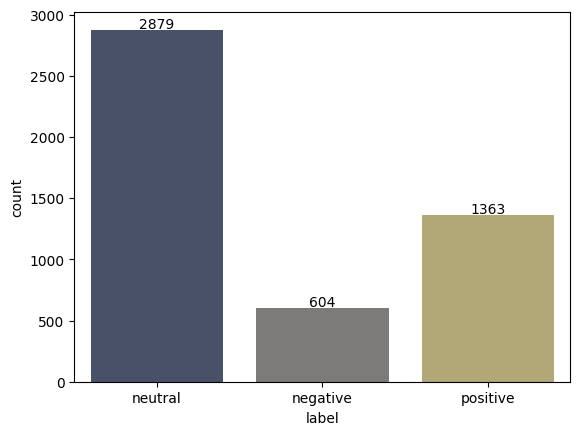

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the plot
ax = sns.countplot(x=df['label'], palette='cividis')

# Annotating bar heights
for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

# Setting custom x-tick labels to reflect actual labels since we are not dealing with 'ham' and 'spam'
plt.xticks(range(len(df['label'].unique())), df['label'].unique())

plt.show()


The F1 score is particularly suitable for evaluating your sentiment analysis model given the class imbalance evident from the count plot. This score, which is the harmonic mean of precision and recall, ensures a balanced measure of a classifier's performance, emphasizing both the accuracy of positive predictions and the model’s ability to identify all relevant cases. The F1 score is valuable in sentiment analysis because it equally weighs all sentiment classes—neutral, negative, and positive—preventing bias toward the majority class and ensuring fairness in evaluating the model's ability to handle each sentiment effectively, which is crucial for deriving accurate business insights from customer feedback.

3. **Data splitting method. (1 point)**
   - Choose the method you will use for dividing your data into training and testing (e.g., Stratified 10-fold cross-validation, Shuffle splits).
   - Explain why your chosen method is appropriate or use more than one method as needed.
   - Convince that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

In [46]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
for fold, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



    Why: This method involves dividing your data into 'k' different subsets (or folds) and ensures that each fold is a good representative of the whole by maintaining the same percentage of samples of each target class as the complete set. Given the class imbalance in your dataset, using stratified folds is crucial to prevent any fold from being overrepresented by one class. This is important for training a model that performs consistently well across all classes.
    
    Realistic Mirroring: In practice, your model needs to perform well on unseen data that likely follows the same distribution as your collected data. Stratified cross-validation provides a rigorous testing environment by repeatedly evaluating the model on different subsets of data, which simulates the process of encountering new data after deployment.

### Modeling (6 points total)
1. **Investigate sequential network architectures. (3 points)**
   - Explore at least two different architectures (e.g., CNN, Transformer, recurrent networks).
   - Include an embedding layer; consider using a pre-trained embedding if possible.
   - Adjust one hyper-parameter of each network to potentially improve generalization performance.
   - Train a total of at least four models.
   - Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

In [109]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Subtract, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# To suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

NUM_CLASSES = 3

def f1_score(y_true, y_pred):
    # Calculate precision and recall for each class
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Return the average F1 score across all classes
    return K.mean(f1)

def build_model(vocab_size, max_text_length):
    EMBED_SIZE = 100
    sequence_input = Input(shape=(max_text_length,))

    embedded_sequences = Embedding(vocab_size, EMBED_SIZE, input_length=max_text_length)(sequence_input)

    x = Conv1D(64, 5, activation='relu', padding='same', kernel_initializer='he_uniform')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 5, activation='relu', padding='same', kernel_initializer='he_uniform')(x)
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 5, activation='relu', padding='same', kernel_initializer='he_uniform')(x)
    x = Dropout(0.2)(x)

    x_mean = GlobalAveragePooling1D()(x)
    x_mean_expanded = Lambda(lambda u: K.expand_dims(u, 1))(x_mean)
    x_tmp = Subtract()([x, x_mean_expanded])

    x_tmp_squared = Lambda(lambda u: K.square(u))(x_tmp)
    x_std = GlobalAveragePooling1D()(x_tmp_squared)
    x = Concatenate(name='concat_1')([x_mean, x_std])

    x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

    model = Model(sequence_input, predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

    return model


def train_model(model, X_train, y_train, X_test, y_test):
    # Model training using built-in metrics
    history = model.fit(
        X_train, y_train, batch_size=64, epochs=10,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
        verbose=0
    )
    # Predicting
    predictions = model.predict(X_test)
    return history, predictions



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


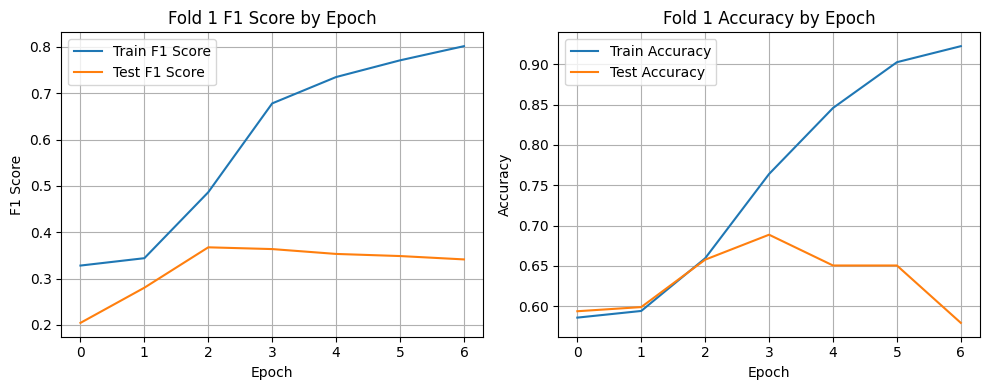

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


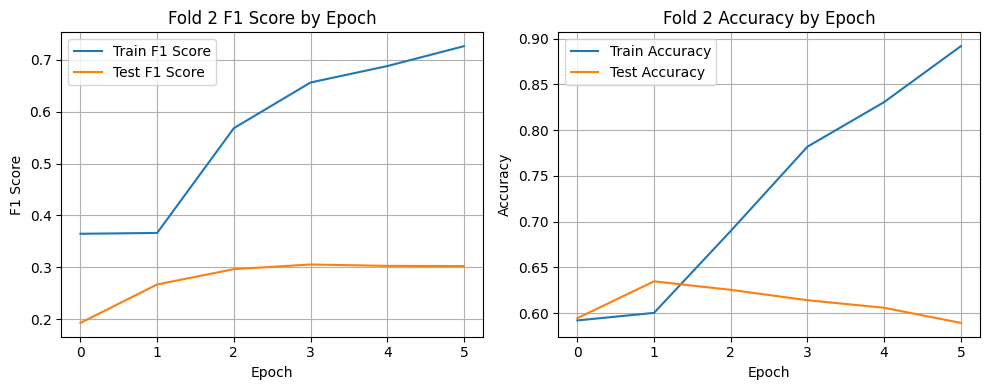

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


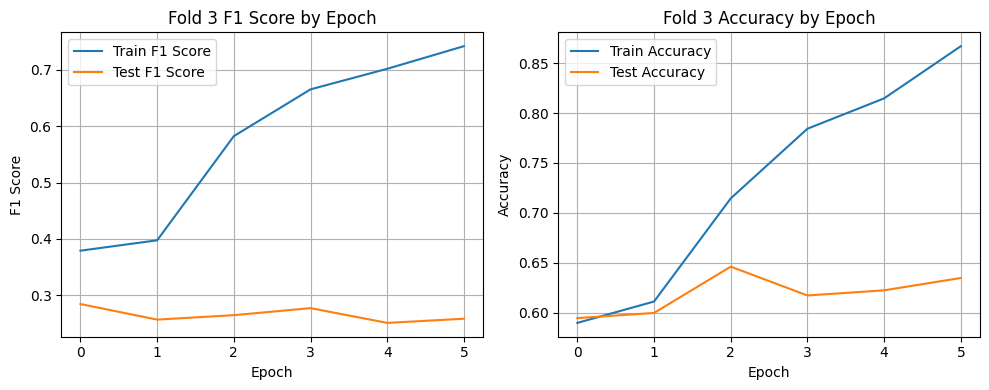

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


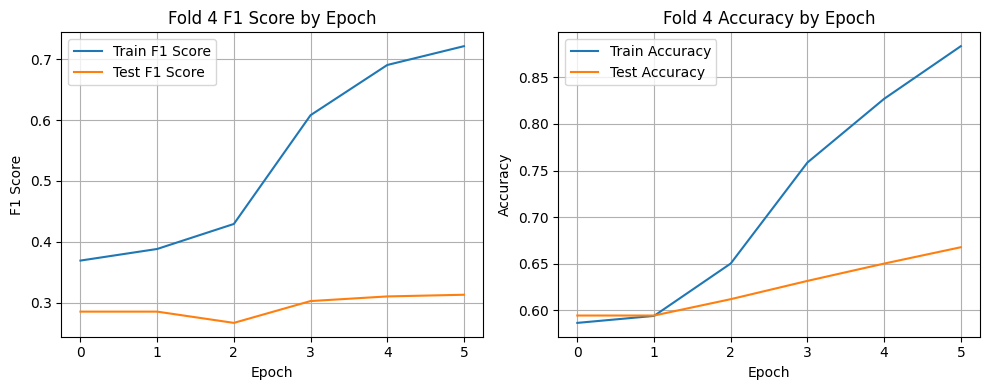

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


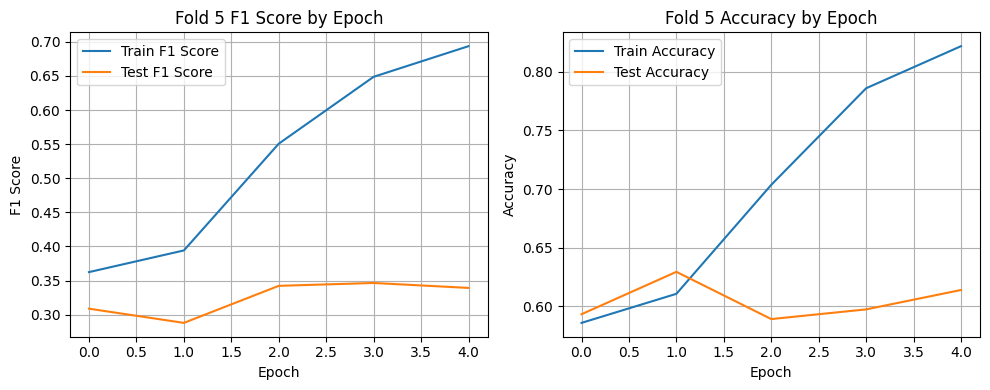

In [111]:
skf = StratifiedKFold(n_splits=5)
for fold, (train_index, test_index) in enumerate(skf.split(X, integer_encoded), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model(vocab_size, max_text_length)
    history, predictions = train_model(model, X_train, y_train, X_test, y_test)

    # Plotting F1 score for each fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['f1_score'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score'], label='Test F1 Score')
    plt.title(f'Fold {fold} F1 Score by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plotting accuracy for each fold
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title(f'Fold {fold} Accuracy by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Show the plot for this fold
    plt.tight_layout()
    plt.show()

The provided plots showcase the training and validation performance of a machine learning model across multiple folds of cross-validation, highlighting trends in accuracy and F1 scores. The model generally shows improvement across epochs in both metrics, with training scores consistently higher than validation, indicating potential overfitting. While the model learns effectively from the training data, the divergence between training and validation performance suggests a need for techniques to enhance generalization, such as regularization or early stopping, to prevent the model from becoming overly specialized to the training data.

In [122]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        out1 = self.dropout1(out1, training=training)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        out2 = self.dropout2(out2, training=training)
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


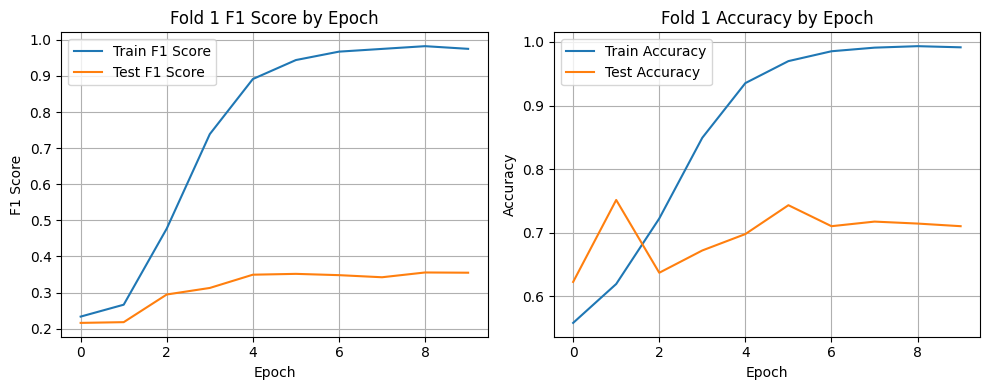

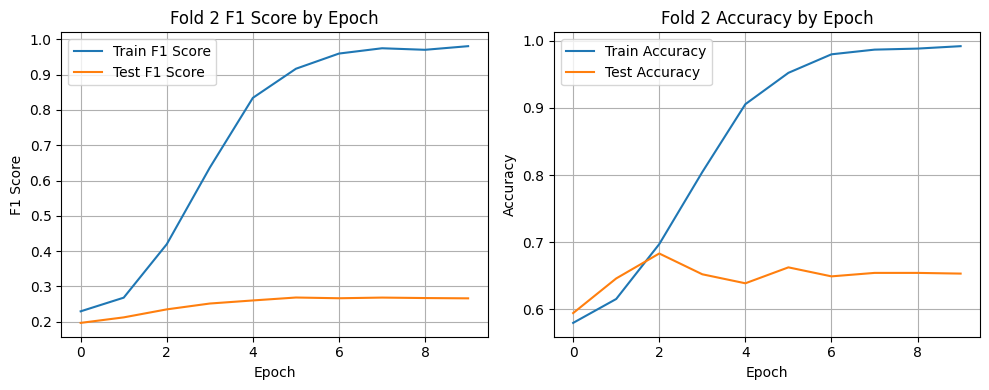

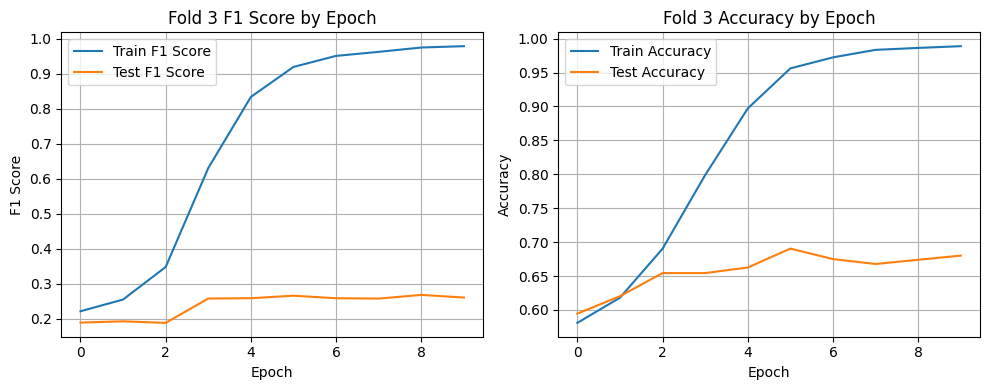

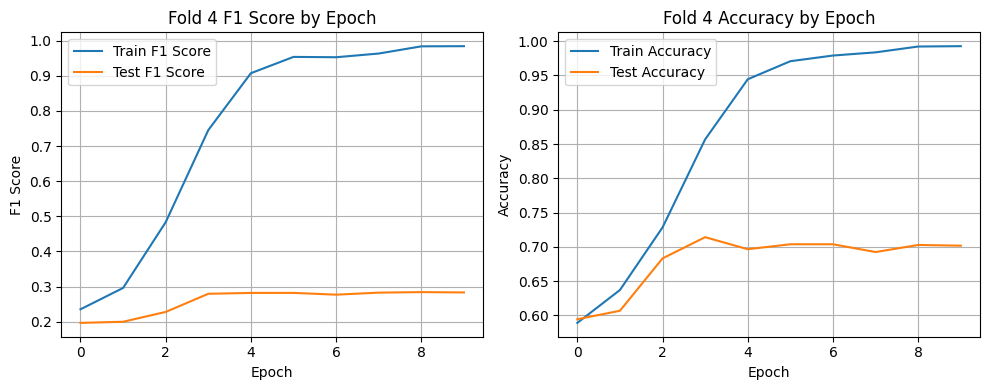

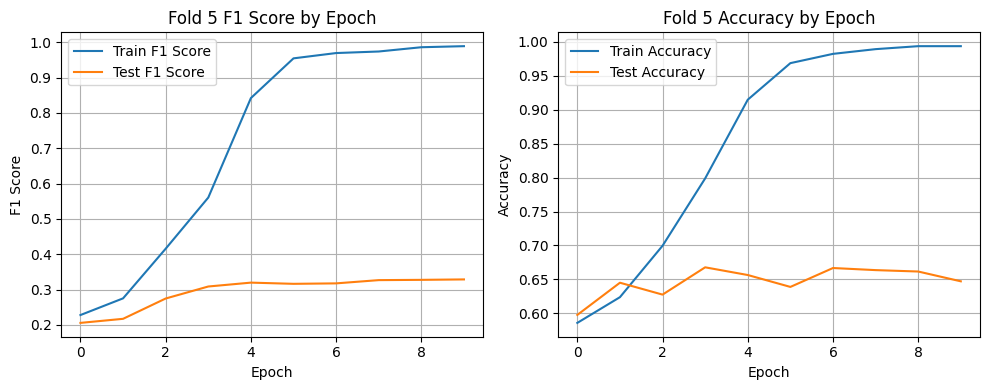

In [129]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Parameters for the transformer
embed_dim = 32 
num_heads = 2 
ff_dim = 32 
NUM_CLASSES = 3 

skf = StratifiedKFold(n_splits=5)
fold_num = 1

for train_index, test_index in skf.split(X, integer_encoded):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding(X_train.shape[1], vocab_size, embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True) 
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model_xformer = Model(inputs=inputs, outputs=outputs)
    model_xformer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

    history_t = model_xformer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)

    # Plot F1 score and accuracy for each fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_t.history['f1_score'], label='Train F1 Score')
    plt.plot(history_t.history['val_f1_score'], label='Test F1 Score')
    plt.title(f'Fold {fold_num} F1 Score by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_t.history['accuracy'], label='Train Accuracy')
    plt.plot(history_t.history['val_accuracy'], label='Test Accuracy')
    plt.title(f'Fold {fold_num} Accuracy by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold_num += 1


2. **Enhance the Transformer network. (1 point)**
   - Using the best parameters and architecture from the previous step, add a second Multi-headed self-attention layer to your network.
   - Visualize the performance of training and validation sets versus the training iterations, showing that the model converged.

In [125]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense, Embedding, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, Layer

class TransformerBlock_Enhanced(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        self.att1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)  # Second attention layer

        self.ffn = Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)  # Additional layer norm for second attention
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)  # Additional dropout for second attention

    def call(self, inputs, training=False):
        attn_output1 = self.att1(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output1)
        out1 = self.dropout1(out1, training=training)

        attn_output2 = self.att2(out1, out1)  # Pass the output of the first attention to the second
        out2 = self.layernorm2(out1 + attn_output2)
        out2 = self.dropout2(out2, training=training)

        ffn_output = self.ffn(out2)
        out3 = self.layernorm3(out2 + ffn_output)
        out3 = self.dropout3(out3, training=training)

        return out3


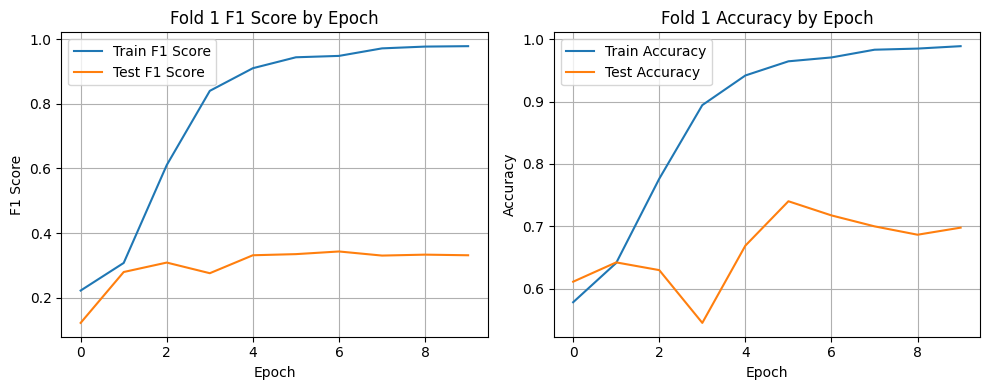

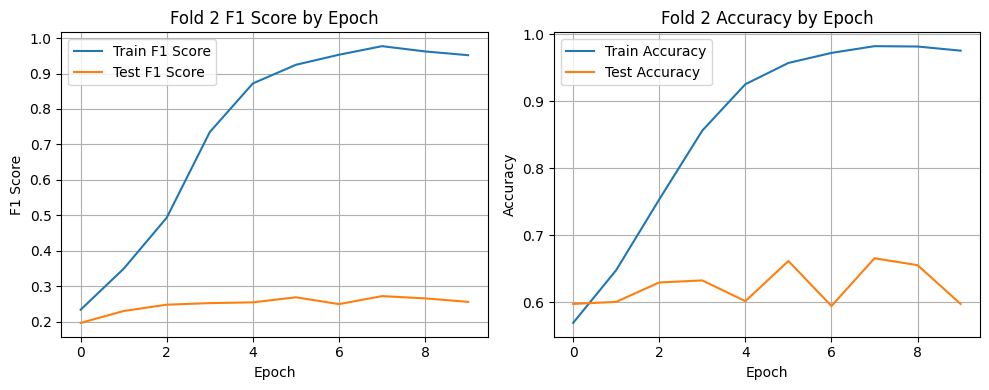

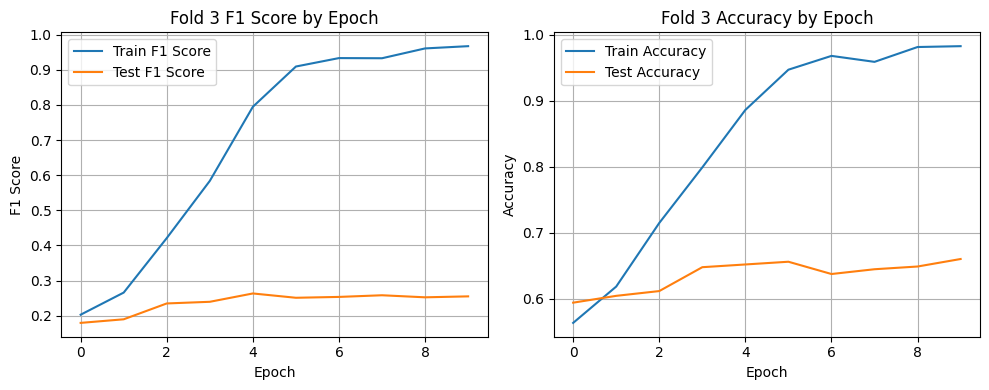

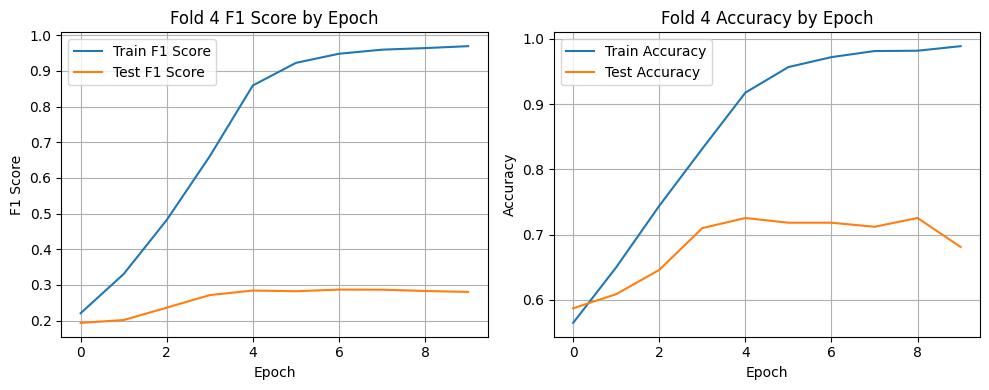

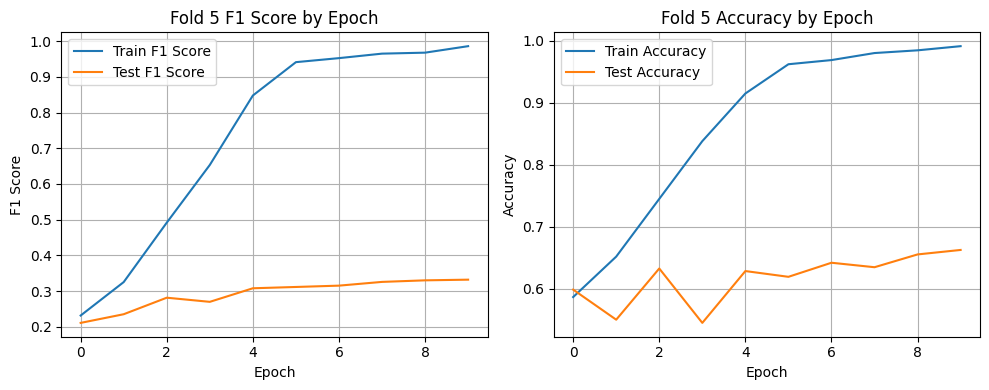

In [128]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Parameters for the transformer
embed_dim = 32 
num_heads = 2
ff_dim = 32
NUM_CLASSES = 3

skf = StratifiedKFold(n_splits=5)
fold_num = 1

for train_index, test_index in skf.split(X, integer_encoded):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding(X_train.shape[1], vocab_size, embed_dim)(inputs)
    x = TransformerBlock_Enhanced(embed_dim, num_heads, ff_dim)(x, training=True)
    x = TransformerBlock_Enhanced(embed_dim, num_heads, ff_dim)(x, training=True)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model_xformer2 = Model(inputs=inputs, outputs=outputs)
    model_xformer2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

    history_t2 = model_xformer2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)

    # Plot F1 score and accuracy for each fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_t2.history['f1_score'], label='Train F1 Score')
    plt.plot(history_t2.history['val_f1_score'], label='Test F1 Score')
    plt.title(f'Fold {fold_num} F1 Score by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_t2.history['accuracy'], label='Train Accuracy')
    plt.plot(history_t2.history['val_accuracy'], label='Test Accuracy')
    plt.title(f'Fold {fold_num} Accuracy by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold_num += 1


3. **Evaluate and compare the models. (2 points)**
   - Use the method of train/test splitting and evaluation criteria argued for at the beginning of the lab.
   - Visualize the results of all the models you trained.
   - Use proper statistical comparison techniques to determine which method(s) is (are) superior.

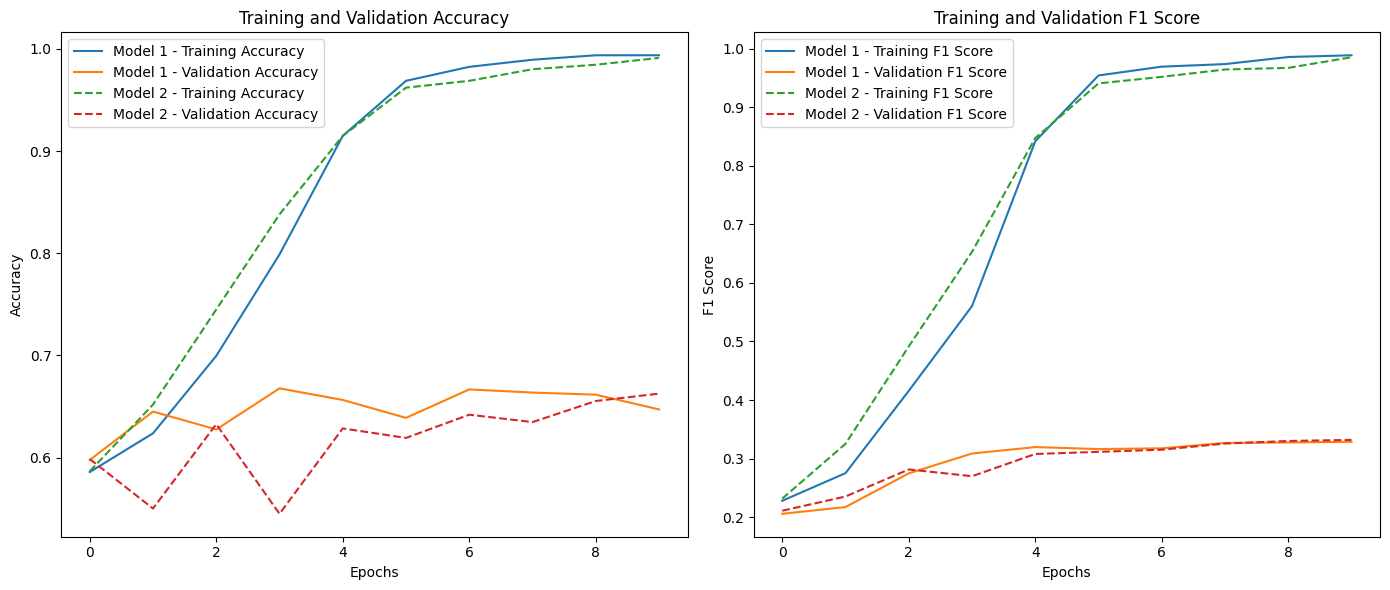

In [130]:
import matplotlib.pyplot as plt

acc_key = 'accuracy'
val_acc_key = 'val_accuracy'
f1_key = 'f1_score'
val_f1_key = 'val_f1_score'

# Plotting
plt.figure(figsize=(14, 6))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_t.history[acc_key], label='Model 1 - Training Accuracy')
plt.plot(history_t.history[val_acc_key], label='Model 1 - Validation Accuracy')
plt.plot(history_t2.history[acc_key], label='Model 2 - Training Accuracy', linestyle='--')
plt.plot(history_t2.history[val_acc_key], label='Model 2 - Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for F1 Score
plt.subplot(1, 2, 2)
plt.plot(history_t.history[f1_key], label='Model 1 - Training F1 Score')
plt.plot(history_t.history[val_f1_key], label='Model 1 - Validation F1 Score')
plt.plot(history_t2.history[f1_key], label='Model 2 - Training F1 Score', linestyle='--')
plt.plot(history_t2.history[val_f1_key], label='Model 2 - Validation F1 Score', linestyle='--')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


### Exceptional Work (1 point total)
- You have free rein to provide additional analyses.
- **For 7000 level students (required)**: Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application?

## Submission Instructions
- Upload a single rendered Jupyter notebook per team that includes all code, visualizations, and textual descriptions.
- Ensure all visualizations and results are reproducible based on the code and descriptions provided.